In [1]:
%load_ext autoreload
%autoreload 2

In [146]:
import torch
import torch.nn as nn
from networks import AdditiveNoisyNet
from noise_generator import GaussianNoiseGenerator
from noise_transformer import ConstantNoiseTransformer, BlockNoiseTransformer
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, random_split
from utils import evaluate_and_plot

from data import generate_data


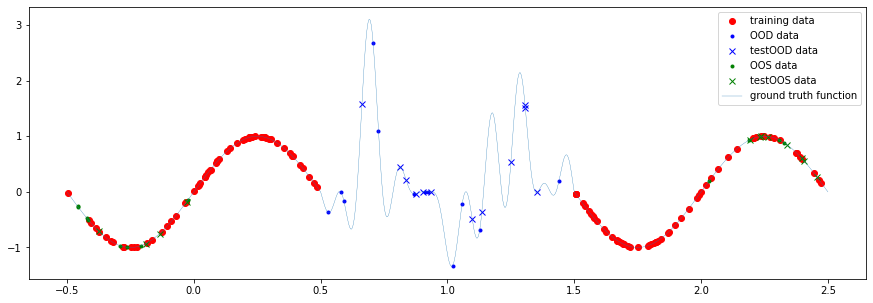

In [94]:
x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test, x_test, y_test = generate_data(128, 24, 24, seed=3, plot=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [100]:
hidden_layers = 4
n_hidden = 64
logsigma = nn.Parameter(-3 * torch.ones(1))
noise_generator = GaussianNoiseGenerator(size=1, logsigma=logsigma)
noise_transformer = ConstantNoiseTransformer(1 + n_hidden * (hidden_layers - 1))
network = AdditiveNoisyNet(hidden_layers=hidden_layers, n_hidden=n_hidden, noise_generator=noise_generator)

### Standard deviation

In [101]:
xx = 20 * torch.randn(16, 1)

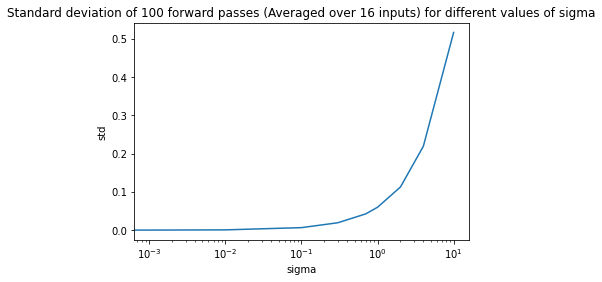

In [102]:
sigmas = [0, 0.001, 0.01, 0.1, 0.3, 0.7, 1, 2, 4, 10]
plt.semilogx(sigmas, [torch.cat([network(xx, sigma) for _ in range(100)], 1).std(1).mean() for sigma in sigmas])
plt.xlabel('sigma')
plt.ylabel('std')
plt.title('Standard deviation of 100 forward passes (Averaged over 16 inputs) for different values of sigma')
plt.show()

### Training networks

In [141]:
hidden_layers = 4
n_hidden = 64
logsigma = nn.Parameter(-3 * torch.ones(1))
noise_generator = GaussianNoiseGenerator(size=1, logsigma=logsigma)
noise_transformer = ConstantNoiseTransformer(1 + n_hidden * (hidden_layers - 1))
network = AdditiveNoisyNet(hidden_layers=hidden_layers, n_hidden=n_hidden, noise_generator=noise_generator)

In [142]:
from train import train_main_model
print([a for a, b in network.named_parameters()])

['noise_generator.mu', 'noise_generator.logsigma', 'model.input_layer.weight', 'model.input_layer.bias', 'model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'model.output_layer.weight', 'model.output_layer.bias']


In [143]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
losses, valid_losses = train_main_model(network, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y), sigma=0.)

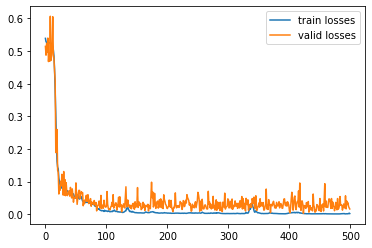

In [144]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()
plt.show()

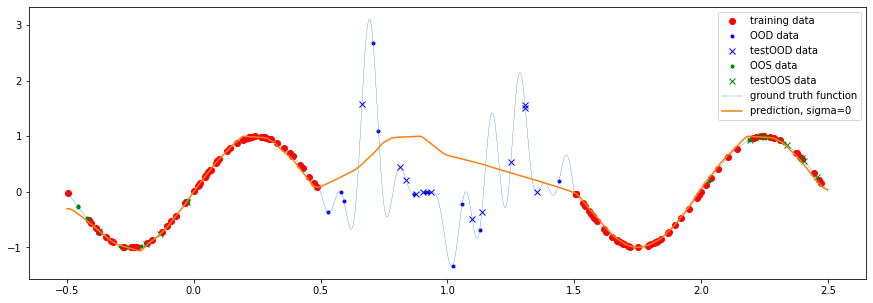

In [145]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, network(x_test, sigma=0.).detach(), label='prediction, sigma=0')
plt.legend()

plt.show()

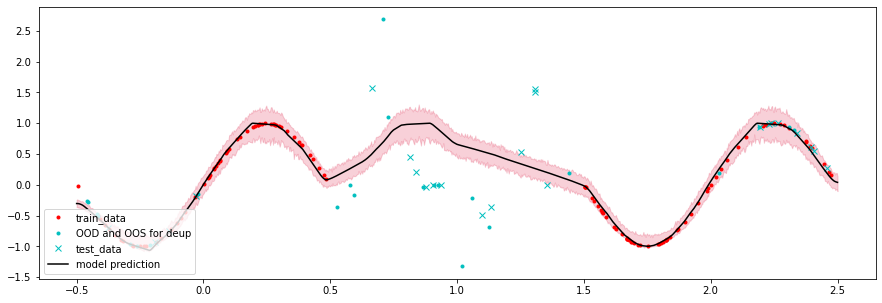

In [150]:
evaluate_and_plot(network, x_test, x, y, oos_ood, test_data, sigma=0.)

In [172]:
samp = torch.utils.data.RandomSampler(full_data, generator=torch.Generator().manual_seed(3))
for x, y in DataLoader(full_data, batch_size=3, sampler=samp):
    print(x)
    break

tensor([[0.7069],
        [2.4665],
        [2.1062]])


In [162]:
full_data